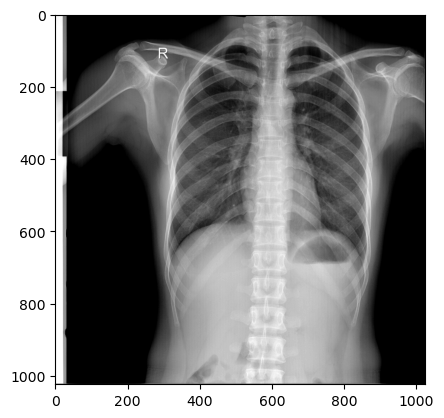

In [1]:
##### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# !pip install torcheval --quiet
# !pip install torchxrayvision --quiet
# !pip install pycocotools --quiet
# !pip install grad-cam --quiet

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import torch 
import torchvision
import cv2
import matplotlib.pyplot as plt
import warnings
import gc, copy
torch.cuda.empty_cache()
gc.collect()

root_path = Path("../data/amia-public-challenge-2024")
img = cv2.imread(str(root_path / "train/train/00JgsY3R0C6VQrT7VDFcoqW2J7dOfULr.png"), 0)
img
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from scipy import stats 
stats.describe(img.flatten())

DescribeResult(nobs=1048576, minmax=(0, 255), mean=93.09384727478027, variance=5716.175982514438, skewness=0.19330046353736843, kurtosis=-1.1984942683938915)

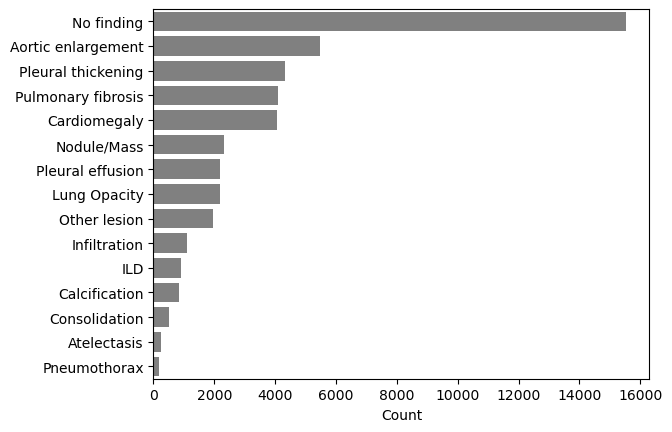

In [3]:
# Class imbalance? 
import pandas as pd
import seaborn as sns

df = pd.read_csv(root_path / "train.csv")
counts = df['class_name'].value_counts()

sns.barplot(y=counts.index, x=counts.values, color="gray")
plt.xlabel("Count")
plt.ylabel("")
plt.show()

Bounding box width statistics:
Mean: 76.82, Std: 58.50, Min: 1.75, Max: 428.83

Bounding box height statistics:
Mean: 61.45, Std: 51.66, Min: 0.44, Max: 439.21


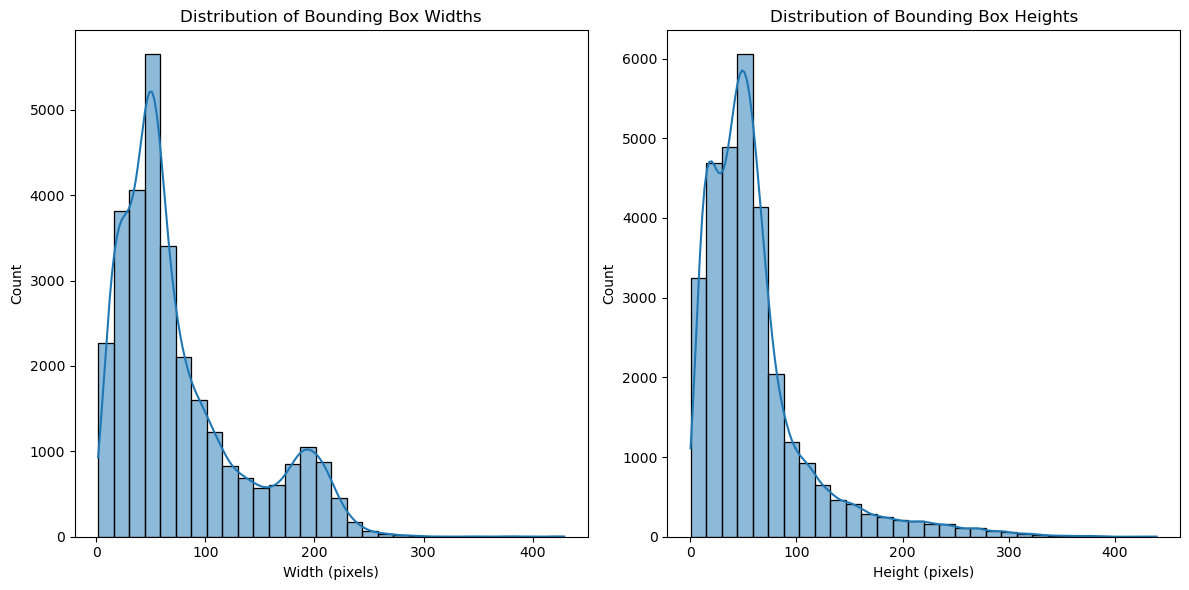

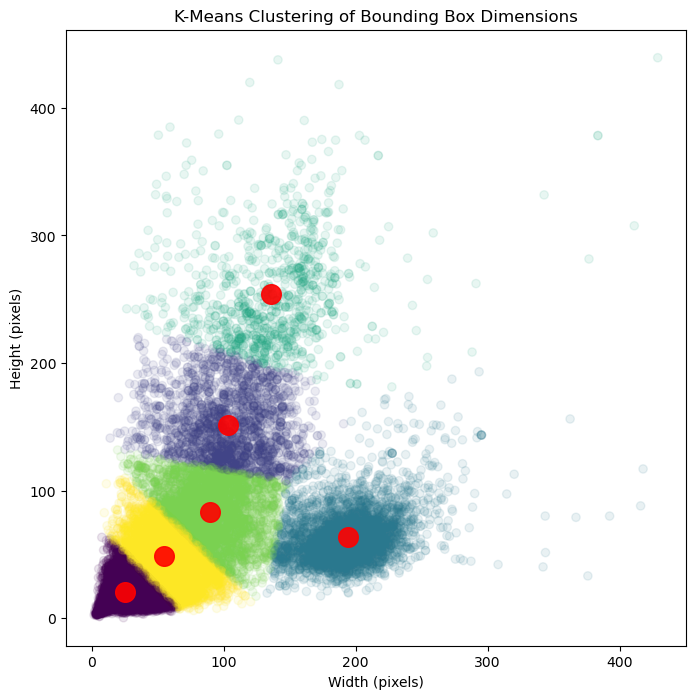

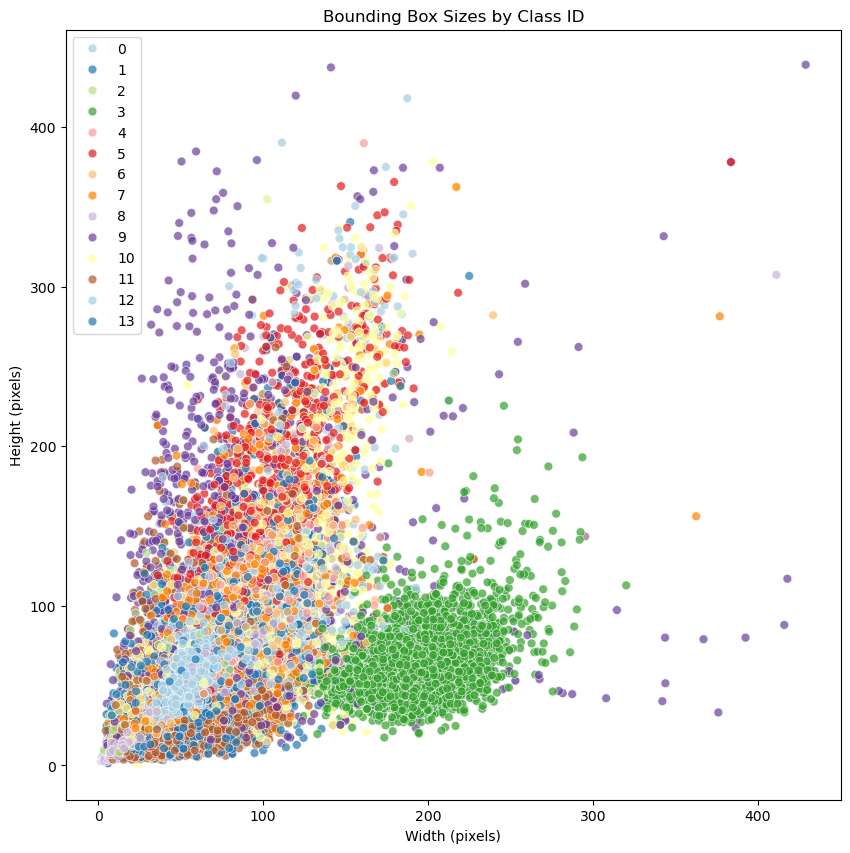


Suggested anchor sizes (width x height):
25 x 20
103 x 151
194 x 63
135 x 254
89 x 83
54 x 48

Aspect ratios:
[0.8211581912134145, 1.4690661767342945, 0.3286102713482433, 1.8698965582724687, 0.924602923280782, 0.8842621378582614]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 


# Load the CSV file
dict_path = "pre-pro/image_dict.json"

with open(dict_path) as f:
    data = json.load(f)

box_widths = []
box_heights = []
class_ids = []
# Iterate over each image in the dictionary
for image_id, image_data in data.items():
    original_width, original_height = image_data["og_dims"]

    # Iterate over each class
    for class_id, radiologists in image_data["classes"].items():
        if class_id == "14":  # ignore no findings
            continue
        # Iterate over each radiologist's annotations
        for rad_id, boxes in radiologists.items():
            for box in boxes:
                x_min, y_min, x_max, y_max = box

                # Convert relative coordinates to absolute pixel values
                box_width = (x_max - x_min) * 448  # targeted image size for training
                box_height = (y_max - y_min) * 448

                # Append the width and height to the respective lists
                box_widths.append(box_width)
                box_heights.append(box_height)
                class_ids.append(int(class_id))

box_widths = np.array(box_widths)
box_heights = np.array(box_heights)
class_ids = np.array(class_ids)

# Print basic statistics
print("Bounding box width statistics:")
print(f"Mean: {box_widths.mean():.2f}, Std: {box_widths.std():.2f}, Min: {box_widths.min():.2f}, Max: {box_widths.max():.2f}")

print("\nBounding box height statistics:")
print(f"Mean: {box_heights.mean():.2f}, Std: {box_heights.std():.2f}, Min: {box_heights.min():.2f}, Max: {box_heights.max():.2f}")

# Plot the distribution of box sizes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(box_widths, bins=30, kde=True)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width (pixels)')

plt.subplot(1, 2, 2)
sns.histplot(box_heights, bins=30, kde=True)
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height (pixels)')

plt.tight_layout()
plt.show()

# Calculate anchor box suggestions using k-means clustering
from sklearn.cluster import KMeans
box_dimensions = np.column_stack((box_widths, box_heights))
num_anchors = 6  # Number of anchors to suggest
kmeans = KMeans(n_clusters=num_anchors, random_state=0).fit(box_dimensions)

# plot the clusters
plt.figure(figsize=(8, 8))
plt.scatter(box_widths, box_heights, c=kmeans.labels_, cmap="viridis", alpha=0.1)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c="red", s=200, alpha=0.9)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("K-Means Clustering of Bounding Box Dimensions")
plt.show()


plt.figure(figsize=(10, 10))
sns.scatterplot(x=box_widths, y=box_heights, hue=class_ids, 
                palette="Paired", alpha=0.7, s=40)
plt.title("Bounding Box Sizes by Class ID")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()



# Output the cluster centers as suggested anchor sizes
print("\nSuggested anchor sizes (width x height):")
for anchor_size in kmeans.cluster_centers_:
    print(f"{int(anchor_size[0])} x {int(anchor_size[1])}")
print("\nAspect ratios:") 
print([height/width for width, height in kmeans.cluster_centers_])

In [5]:
import torch
from torch import Tensor
from typing import List

def calculate_scales(widths: List[float], heights: List[float], aspect_ratios: List[float]) -> List[float]:
    """
    Calculate the scales needed for the generate_anchors function given desired widths, heights, and aspect ratios.

    Args:
        widths (List[float]): Desired widths of the anchors.
        heights (List[float]): Desired heights of the anchors.
        aspect_ratios (List[float]): Aspect ratios (height/width) corresponding to each anchor.

    Returns:
        List[float]: Calculated scales that can be used in the generate_anchors function.
    """
    scales = []
    for width, height, aspect_ratio in zip(widths, heights, aspect_ratios):
        # Calculate the scale based on the width and aspect ratio
        scale = width * torch.sqrt(torch.tensor(aspect_ratio))
        scales.append(scale.item())
    return scales


ratios = [height/width for width, height in kmeans.cluster_centers_]
widths = [x for x, _ in kmeans.cluster_centers_]
heights = [y for _, y in kmeans.cluster_centers_]
sizes = calculate_scales(widths, heights, ratios)
print("widths:",widths)
print("heights:",heights)
print("ratios:",ratios)
print("sizes:",sizes) # -> one size is '111'. test below v



# This is the pytorch function from anchors_utils.py to check if a correct box would be generated :) 
def generate_anchors(
    scales: List[int],
    aspect_ratios: List[float],
    dtype: torch.dtype = torch.float32,
    device: torch.device = torch.device("cpu"),
) -> Tensor:
    scales = torch.as_tensor(scales, dtype=dtype, device=device)
    aspect_ratios = torch.as_tensor(aspect_ratios, dtype=dtype, device=device)
    h_ratios = torch.sqrt(aspect_ratios)
    w_ratios = 1 / h_ratios

    ws = (w_ratios[:, None] * scales[None, :]).view(-1)
    hs = (h_ratios[:, None] * scales[None, :]).view(-1)

    base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
    return base_anchors.round()

print("\nAnchors:\n",generate_anchors([widths[0]], [ratios[0]]))



widths: [25.295237945546454, 103.0872928720659, 194.52595336463753, 135.9667324352739, 89.8717785159817, 54.863213473992936]
heights: [20.771391837677854, 151.44205520945434, 63.92322631942926, 254.24372502027234, 83.09570913631966, 48.51346243628716]
ratios: [0.8211581912134145, 1.4690661767342945, 0.3286102713482433, 1.8698965582724687, 0.924602923280782, 0.8842621378582614]
sizes: [22.921982876580348, 124.94699475587475, 111.51110501618422, 185.9265675829539, 86.41735454830678, 51.59073992495707]

Anchors:
 tensor([[-14., -11.,  14.,  11.]])


In [6]:
import os
import numpy as np
import time
from tqdm.autonotebook import tqdm as tqdm
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms, tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2
import torchxrayvision as xrv

# import medmnist
# from medmnist import ChestMNIST, DermaMNIST, INFO, Evaluator
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torch.optim import lr_scheduler, SGD
from tqdm.autonotebook import tqdm
from torcheval.metrics.functional import multiclass_confusion_matrix
from torchinfo import summary
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import json

import torch.nn.functional as F
from torchvision.transforms.v2 import functional as F2
import torch.utils.data as data
import torchvision.transforms as transforms

import torch.optim as optim


import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN, rpn
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import get_cmap

from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

import random, warnings


# --------------- Constants ------------------

ROOT = str(root_path)
# call augment data function
pic_folder_path = ROOT + "/train/train"
inf_folder_path = ROOT + "/test/test"
dict_path = dict_path
batch_size = 10 # base model hat 10

class_names = {
    0: "Aortic enlargement",
    1: "Atelectasis",
    2: "Calcification",
    3: "Cardiomegaly",
    4: "Consolidation",
    5: "ILD",
    6: "Infiltration",
    7: "Lung Opacity",
    8: "Nodule/Mass",
    9: "Other lesion",
    10: "Pleural effusion",
    11: "Pleural thickening",
    12: "Pneumothorax",
    13: "Pulmonary fibrosis",
    14: "No finding",
}

label_mapping = {
    "14": 0,  # 'No finding' mapped to 0 (background class)
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5,
    "5": 6,
    "6": 7,
    "7": 8,
    "8": 9,
    "9": 10,
    "10": 11,
    "11": 12,
    "12": 13,
    "13": 14,
}


# Detect OS and set num_workers accordingly
if os.name == "nt":  # Windows
    num_workers = 0
else:  # Linux and others
    num_workers = 2


# --------------- Helper functions ------------------
# Custom collate function to handle varying sizes of bounding boxes
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, targets


def get_device():
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        warnings.warn("CUDA not available. Using CPU instead.", UserWarning)
    print("Device set to {}.".format(device))
    return device


# set seeds for reproducibility
def set_seeds(seed=123420):
    random.seed(seed)
    np.random.seed(seed + 1)
    torch.random.manual_seed(seed + 2)
    device = get_device()
    if device == "cuda":
        torch.cuda.manual_seed(seed + 3)
        torch.cuda.manual_seed_all(seed + 4)
        torch.backends.cudnn.deterministic = True
    print("Seeds set to {}.".format(seed))
    return


def string_to_tensor(s):
    return torch.tensor([ord(c) for c in s], dtype=torch.int64)


def tensor_to_string(t):
    return "".join([chr(c) for c in t])


class GrayscaleImageListDataset(Dataset):
    def __init__(self, img_dir, img_list, transform=None):
        self.img_dir = img_dir
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image


def get_mean_and_std(
    img_dir, img_list, batch_size=32, print_values=False, leave_pbar=False
):
    """
    Compute the mean and std color values of all images (grayscale values) in the specified list.

    Parameters:
    - img_dir (str): Directory containing the images.
    - img_list (list): List of image filenames to include in the calculation.
    - batch_size (int): Batch size for processing images.
    - print_values (bool): Whether to print the mean and std values.
    - leave_pbar (bool): Whether to leave the progress bar after completion.

    Returns:
    - mean (torch.Tensor): Mean grayscale values.
    - std (torch.Tensor): Standard deviation of grayscale values.
    """
    device = get_device()
    transform = v2.ToDtype(torch.float32, scale=True)
    dataset = GrayscaleImageListDataset(img_dir, img_list, transform=transform)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
    )

    channels_sum = torch.zeros(1).to(device)
    channels_squared_sum = torch.zeros(1).to(device)
    num_pixels = 0
    
    for images in tqdm(
        dataloader,
        desc="Calculating mean and std of all grayscale values",
        leave=leave_pbar,
        colour="CYAN",
    ):
        images = images.to(device)
        non_black_pixels = images[images != 0].view(-1)
        num_pixels += non_black_pixels.shape[0]

        channels_sum += torch.sum(non_black_pixels)
        channels_squared_sum += torch.sum(non_black_pixels**2)

    mean = channels_sum / num_pixels
    std = (channels_squared_sum / num_pixels - mean**2) ** 0.5

    if print_values:
        print(
            "Mean: ", mean.cpu().detach().numpy(), ", Std: ", std.cpu().detach().numpy()
        )

    return mean, std

# --------------- Data Loader ------------------
class XRayImageDataset(Dataset):
    """
    load image and targets from dict
    structure of the dict
        img_id: {
            "classes": [
                class_id: [
                rad_id: [[bbox],[bbox]]]
    """

    def __init__(
        self,
        dict,
        img_size,
        img_dir,
        mean=None,
        std=None,
        transform_norm=None,
        nms=True,
        nms_iou_thresh=0.5,
        device=None,
    ):
        self.dict = dict
        self.keys = list(dict.keys())
        self.img_size = img_size
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform_norm = transform_norm
        self.nms = nms
        self.nms_iou_thresh = nms_iou_thresh
        if device is None:
            self.device = get_device()
        else:
            self.device = "cpu"

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        img_id = self.keys[idx]
        img_path = os.path.join(self.img_dir, img_id) + ".png"

        image = read_image(img_path)

        box_list = []
        label_list = []
        area_list = []
        iscrowd_list = []
        for class_id in self.dict[img_id]["classes"]:
            if class_id == "14":
                continue
            # collect all boxes for the current class
            box = []
            for rad in self.dict[img_id]["classes"][class_id].items():
                for box in rad[1]:
                    # Ensure the box has 4 coordinates
                    if len(box) == 4 and box[2] > box[0] and box[3] > box[1]:
                        box_list.append([coord * image.shape[-1] for coord in box])
                        label_list.append(label_mapping[class_id])
                        area_list.append((box[2] - box[0]) * (box[3] - box[1]))
                        iscrowd_list.append(0)
                    else:
                        print(f"Invalid Box found at {img_id} with {box}")
            if self.nms:
                # Non-maximum suppression
                boxes_to_keep = torchvision.ops.nms(
                    torch.tensor(box_list).float(),
                    torch.tensor([1.0] * len(box_list)),
                    iou_threshold=self.nms_iou_thresh,
                )
                # now keep only the values of the indices that are in boxes_to_keep
                box_list = [box_list[i] for i in boxes_to_keep]
                label_list = [label_list[i] for i in boxes_to_keep]
                area_list = [area_list[i] for i in boxes_to_keep]
                iscrowd_list = [iscrowd_list[i] for i in boxes_to_keep]

        if len(box_list) > 0:
            boxes_tensor = tv_tensors.BoundingBoxes(
                box_list, format="XYXY", canvas_size=(image.shape[-1], image.shape[-1])
            )
        else:
            empty_boxes = np.array([]).reshape(-1, 4)
            boxes_tensor = torch.as_tensor(empty_boxes, dtype=torch.int16)
        labels_tensor = torch.tensor(label_list, dtype=torch.int64)
        areas_tensor = torch.tensor(area_list, dtype=torch.int32)
        iscrowd_tensor = torch.tensor(iscrowd_list, dtype=torch.uint8)

        if self.transform_norm:
            image, boxes_tensor = self.transform_norm(image.to(device=self.device), boxes_tensor.to(device=self.device))

        target = {
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "area": areas_tensor,
            "iscrowd": iscrowd_tensor,
            "filename": string_to_tensor(img_id),
        }

        return image, target

class XRayInferenceDataset(Dataset):
    """
    Dataset for X-ray images, focusing on inference.
    It loads only the image and the filename.
    """

    def __init__(self, img_dir, transform=None):
        """
        Args:
            img_dir (str or Path): Directory where the images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = Path(img_dir)
        self.file_list = [p.stem for p in self.img_dir.glob("*.png")]
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_id = self.file_list[idx]
        img_path = self.img_dir / f"{img_id}.png"

        image = read_image(str(img_path))

        if self.transform:
            image = self.transform(image)

        return image, img_id

def load_and_augment_images(
    pic_folder_path,
    inf_folder_path,
    dict_path,
    batch_size,
    class_names,
    img_size=448,
    use_normalize=False,
):
    # split folders into 70% train and 30% test by ids
    set_seeds()
    train_percent = 0.8
    # Use the images in the ONE folder and split them into train and test
    train_ids = random.sample(
        os.listdir(pic_folder_path),
        int(train_percent * len(os.listdir(pic_folder_path))),
    )
    test_ids = [id for id in os.listdir(pic_folder_path) if id not in train_ids]

    # normalize on all train images or use precomputed
    if use_normalize:
        mean, std = get_mean_and_std(
            pic_folder_path, train_ids, print_values=True, leave_pbar=True
        )
        print("Mean: ", mean, ", Std: ", std)
    else:
        mean = 0.57062465
        std = 0.24919559

    # remove file extension
    train_ids = [id.split(".")[0] for id in train_ids]
    test_ids = [id.split(".")[0] for id in test_ids]
    # print first values and lengths
    print(f"Length of train_ids: {len(train_ids)}")
    print(f"Length of test_ids: {len(test_ids)}")

    # Data augmentation and normalization for training1
    data_transforms = {
        "train": v2.Compose(
            [
                #v2.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
                v2.Resize(img_size, antialias=True),
                v2.RandomRotation(
                    degrees=(-6, 6)
                ),  # all images are upright and will always be. No rotation needed? COuld be interesting to try for generalizing
                v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0),
                v2.RandomPerspective(distortion_scale=0.1, p=0.1),
                # v2.RandomEqualize(p=1.),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[mean], std=[std], inplace=True), # maybe exclude, since retinanet expects values between 0-1
            ]
        ),
        "test": v2.Compose(
            [
                v2.ToTensor(),
                v2.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
                v2.Resize(img_size, antialias=True),
                v2.ToDtype(torch.uint8, scale=True),
                # Equalize all images to have a more uniform distribution of pixel intensities, regardless of they are generally dark or light
                # v2.RandomEqualize(p=1.),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[mean], std=[std], inplace=True),
            ]
        ),
    }

    # load image_dict.json
    with open(dict_path) as f:
        og_dict = json.load(f)

    # train_dict where keys match train_ids
    train_dict = {
        k: og_dict[k] for k in train_ids}# if "14" not in og_dict[k]["classes"]}
    #print("Remaining train dict length: ", len(train_dict))
    test_dict = {
        k: og_dict[k] for k in test_ids}# if "14" not in og_dict[k]["classes"]}
    #print("Remaining test dict length: ", len(test_dict))

    # size for images
    img_size = img_size
    train_dataset = XRayImageDataset(
        train_dict, img_size, pic_folder_path, mean, std, data_transforms["train"]
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    test_dataset = XRayImageDataset(
        test_dict, img_size, pic_folder_path, mean, std, data_transforms["test"]
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  # no need for batches
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    # image folder
    inference_dataset = XRayInferenceDataset(
        inf_folder_path, transform=data_transforms["test"]
    )

    inference_dataloader = torch.utils.data.DataLoader(
        inference_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    print("Loaded the training dataset.")

    dataloaders = {"train": train_dataloader, "test": test_dataloader, "inference": inference_dataloader}

    num_classes = class_names.items().__len__()

    return dataloaders, class_names, num_classes


# for EigenCam
def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

def retinanet_reshape_transform(x):
    # Use the feature map with the largest spatial dimensions as the target size
    target_size = x["0"].size()[-2:]
    activations = []
    # Interpolate all feature maps to the target size
    for key, value in x.items():
        activations.append(
            F.interpolate(torch.abs(value), size=target_size, mode="bilinear")
        )
    # Concatenate the interpolated feature maps along the channel dimension
    return torch.cat(activations, dim=1)


# --------------- Model ------------------

# this nacho generator workes great so far, but we can do better:
# anchor_generator = rpn.AnchorGenerator(
#   sizes=((10,), (60,), (200,))*5, # times 5 'cause we want all sizes on all layers
#   aspect_ratios=((0.3, 1.0, 1.5),)*5, # times 5 'cause 5 feature maps'
# )

from torchvision.ops.feature_pyramid_network import LastLevelP6P7
from torchvision.models.detection.retinanet import RetinaNet, RetinaNetHead
from functools import partial


# considering the bboxes of the k-means analysis, we chose the following anchors at each level. We rounded up to arbitrary values to end up a bit more in the upper right of each cluster.
# two cluster sizes were combined
# anchor_generator = rpn.AnchorGenerator(
#   sizes=((30,), (60,), (90,), (130,), (200,), (250,)), # times 5 'cause we want all sizes on all layers
#    aspect_ratios=((0.32, 1., 1.8,),)*6, # times 5 'cause 5 feature maps'
# )
def _default_anchorgen():
    anchor_sizes = tuple(
        (x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3)))
        for x in [30, 60, 90, 130, 220]
    )
    aspect_ratios = ((0.32, 1., 1.8),) * len(anchor_sizes)
    anchor_generator = rpn.AnchorGenerator(anchor_sizes, aspect_ratios)
    return anchor_generator

# use pre-trained on chest x-rays
backbone = xrv.models.ResNet(weights="resnet50-res512-all")
backbone = torch.nn.Sequential(*list(backbone.model.children())[:-2])

# Define the layers to return feature maps from
return_layers = {
    "4": "0",  # Corresponds to layer1
    "5": "1",  # Corresponds to layer2
    "6": "2",  # Corresponds to layer3
    "7": "3",  # Corresponds to layer4
}

# Construct the BackboneWithFPN
backbone = BackboneWithFPN(
    backbone,
    return_layers=return_layers,  # The layers we want to use
    in_channels_list=[
        256,
        512,
        1024,
        2048,
    ],  # Corresponding in_channels for these layers
    out_channels=256,  # Out channels for FPN layers
)
# from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
# backbone = _resnet_fpn_extractor(
#         backbone, trainable_layers=5, returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(2048, 256)
#     )

anchor_generator = _default_anchorgen()
# anchor_generator = rpn.AnchorGenerator(
#     sizes=((30,), (60,), (90,), (130,), (220,)),
#     aspect_ratios=((0.32, 1., 1.8),) * 5,
# )


head = RetinaNetHead(
    backbone.out_channels,
    anchor_generator.num_anchors_per_location()[0],
    num_classes=15,
    #norm_layer=partial(nn.GroupNorm, 32),
)
head.regression_head._loss_type = "giou" # generalized IoU loss takes area + position into account

model = RetinaNet(
    backbone,
    num_classes=15,
    image_mean=[0],
    image_std=[1],
    anchor_generator=anchor_generator,
    head=head,
    nms_thresh=0.5, # lower NMS -> fewer proposals
    score_thresh=0.1, # increase to filter low-confidence detections
    detections_per_img=100, # default 300 -> overkill?
    fixed_size=(448, 448), # resize all images to this size
)


'''model = torch.load("/kaggle/input/supplements/fasterrcnn_xrv_15epo_map30.pt")
model.image_mean=[0]
model.image_std=[1]
model.box_detections_per_img=50
model.rpn_anchor_generator=anchor_generator
'''


def plot_cam_bbox(cam_img, target, pred, title="CAM Visualization", save_path="cam_visualization.png", score_thresh=0.5, ax=None):
    """
    Plot the CAM images with target and predicted bounding boxes.
    """
    if ax is None:
        ax = plt.gca()
    
    target_color = "green"
    prediction_color = "black"

    # Plot target bounding boxes in green for the first image
    ax.imshow(cam_img)
    ax.set_title(title)
    for box, label in zip(target["boxes"].cpu().numpy(), target["labels"].cpu().numpy()):
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            color=target_color,
            linestyle='--',
            label=label,
            linewidth=4,
        )
        ax.add_patch(rect)
        ax.text(box[0], box[1], f"{label}", color=target_color, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Plot predicted bounding boxes in red with labels and scores for the first image
    for box, label, score in zip(pred["boxes"].cpu().numpy(), pred["labels"].cpu().numpy(), pred["scores"].cpu().numpy()):
        lw = 2 + (score_thresh-score)*3 # Adjust linewidth based on score
        if score >= score_thresh:
            rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                fill=False,
                linewidth=lw,
                color=prediction_color,
                linestyle='-',
                label=label,
            )
            ax.add_patch(rect)
            ax.text(box[0], box[1], f"{label}@{score:.2f}", color=prediction_color, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    return ax

# TODO: combine functions into one
def plot_img_bbox(img, target, pred, title):
    img = img.cpu().permute(1, 2, 0).numpy()
    # plot the image and bboxes
    # different colors for target and pred
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap="gray")
    for box in target["boxes"]:
        box = box.cpu().numpy()
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)
    for box in pred["boxes"]:
        box = box.cpu().numpy()
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
    ax.set_title(title)
    # plt.savefig(f"{title}.png")


def train_and_evaluate(model, train_dataloader, val_dataloader, num_epochs=30, lr=0.0005):
    set_seeds()
    torch.cuda.empty_cache()
    torch.clear_autocast_cache()
    device = get_device()
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    # optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    optimizer = torch.optim.Adamax(params, lr=lr, weight_decay=0.00005)
    # optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=0.00005)  
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # let's try this one as well
    loss_list = []
    map_list = []
    
    # Initialize MeanAveragePrecision metric
    metric = MeanAveragePrecision(
        box_format="xyxy",
        iou_type="bbox",
        iou_thresholds=[0.4],
        class_metrics=True,
    )
    best_map={"map": 0.0}

    print("Starting the training...")

    scaler = torch.cuda.amp.GradScaler()
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        train_loss = 0
        loss_dict = {}
        for images, targets in tqdm(
            train_dataloader, desc="Training", leave=True, colour="BLUE"
        ):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            found_invalid_box = False
            # check if the targets(bounding boxes) are smaller than the image size and have the correct format (positive width and height)
            for target in targets:
                for box in target["boxes"]:
                    if box[2] <= box[0] or box[3] <= box[1]:
                        found_invalid_box = True
                        print(f"Invalid Box found in training with {box}")
                    if box[2] > images[0].shape[-1] or box[3] > images[0].shape[-2]:
                        found_invalid_box = True
                        print(f"Box outside of image found in training with {box}")
                if found_invalid_box:
                    print(f"Image: {tensor_to_string(target['filename'])}")
                    warnings.warn("Invalid box found in training data. Removing it from this batch")
            if found_invalid_box:
                continue

            # sanity-check plot if input image seems correct
            '''
            if len(targets[0]["boxes"]>0):
                plot_img_bbox(
                    images[0],
                    targets[0],
                    {"boxes": []},
                    f"Image {tensor_to_string(target['filename'])}",
                )
                print(images[0].max())
                print(images[0].mean())
                print(images[0])
                raise ValueError("Plottet an image.")
            '''
            
            # Apply mixed precision training
            with torch.cuda.amp.autocast():
                # when training the fasterrcnn model, the model returns a dict with losses.
                # include class weights in the losses to balance the classes
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()
            optimizer.zero_grad()
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        lr_scheduler.step()  # TODO: adjust scheduler

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
        print(loss_dict)
        loss_list.append(loss_dict)


        cam_plotted=0
        model.eval()
        with torch.no_grad():
            for images, targets in tqdm(
                val_dataloader, desc="Validation", leave=True, colour="GREEN"
            ):
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                predictions = model(images)
                metric.update(predictions, targets)
            #     cam_img_list = []
            #     cam_target_list = []
            #     cam_pred_list = []
            #     cam_filename_list = []
            #     # check if image gets predictions and plot
            #     for image, target, prediction in zip(images, targets, predictions):
            #         if (len(target["boxes"]) > 0) and (len(prediction["boxes"]) > 0):
            #             if cam_plotted < 3:
            #                 # TODO: the target_size in retinanet_reshape_transforms is probs wrong and insanely memory hungry. 
            #                 # we should apply gradcam in the end only once and not for every epoch on some images.
            #                 cam_target_layers = [model.backbone]
            #                 cam_targets = [FasterRCNNBoxScoreTarget(labels=prediction["labels"], bounding_boxes=prediction["boxes"])]
            #                 cam = EigenCAM(model, cam_target_layers, reshape_transform=retinanet_reshape_transform)
            #                 grayscale_cam = cam(image.unsqueeze(0), targets=cam_targets)[0]

            #                 # Prepare the image for visualization
            #                 image_np = image.cpu().numpy().transpose(1, 2, 0)
            #                 #print(f"max: {image_np.max()} min: {image_np.min()}")
            #                 image_np = (image_np - image_np.min()) / image_np.ptp() # Normalize to [0, 1]

            #                 image_np = image_np.astype(np.float32)
            #                 # Convert grayscale to RGB by repeating the single channel three times
            #                 image_np = np.repeat(image_np, 3, axis=-1)  # Now shape is [H, W, 3]

            #                 # Convert CAM to an RGB image for visualization
            #                 cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
            #                 cam_img_list.append(cam_image)
            #                 cam_target_list.append(target)
            #                 cam_pred_list.append(prediction)
            #                 cam_filename_list.append(tensor_to_string(target["filename"]))

            #                 model.eval()
            #                 cam_plotted += 1

            # # Plot the CAM with bounding boxes
            # if (len(cam_img_list) > 0) and (len(cam_target_list) > 0) and (len(cam_pred_list) > 0):
            #     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
            #     plot_cam_bbox(cam_img_list[0], cam_target_list[0], cam_pred_list[0], title=f"Image {cam_filename_list[0]}", ax=ax1)
            # if (len(cam_img_list) > 1) and (len(cam_target_list) > 1) and (len(cam_pred_list) > 1): 
            #     plot_cam_bbox(cam_img_list[1], cam_target_list[1], cam_pred_list[1], title=f"Image {cam_filename_list[1]}", ax=ax2)
            # if (len(cam_img_list) > 2) and (len(cam_target_list) > 2) and (len(cam_pred_list) > 2): 
            #     plot_cam_bbox(cam_img_list[2], cam_target_list[2], cam_pred_list[2], title=f"Image {cam_filename_list[2]}", ax=ax3)
            #     fig.suptitle(f"Class Activation Maps")
            #     plt.show()

        # Calculate and print the mAP
        map_metric = metric.compute()
        print(f"Epoch [{epoch+1}/{num_epochs}], Val mAP: {map_metric['map']:.4f}")
        print(map_metric)
        if map_metric["map"] >= best_map["map"]:
            best_map["map"] = map_metric["map"]
            model_path = 'retinanet_xrv_resnet50_best_checkpoint.pt'
            if os.path.exists(model_path):
                os.remove(model_path)
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "loss": train_loss,
                "map": map_metric["map"],
            }, model_path)
            print(f"New best model saved to {model_path}!")
        map_list.append(map_metric)
        # Reset the metric for the next epoch
        metric.reset()
    print("Finished Training!")
    return copy.deepcopy(model), loss_list, map_list

C:\Users\feige\AppData\Local\Temp\ipykernel_1168864\2005495334.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as tqdm
c:\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [7]:
# --------------- Main ------------------

dataloaders, class_names, num_classes = load_and_augment_images(
    pic_folder_path, inf_folder_path, dict_path, batch_size, class_names, use_normalize=False
)

Device set to cuda.
Seeds set to 123420.
Length of train_ids: 6858
Length of test_ids: 1715
Device set to cuda.
Device set to cuda.
Loaded the training dataset.


In [8]:
final_model, loss_list, map_list = train_and_evaluate(model, dataloaders["train"], dataloaders["test"], 30)

Device set to cuda.
Seeds set to 123420.
Device set to cuda.
Starting the training...


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 406.2697
{'classification': tensor(0.3069, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1064, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [1/30], Val mAP: 0.0379
{'map': tensor(0.0379), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0218), 'map_medium': tensor(0.0506), 'map_large': tensor(0.0486), 'mar_1': tensor(0.1079), 'mar_10': tensor(0.1551), 'mar_100': tensor(0.1571), 'mar_small': tensor(0.0236), 'mar_medium': tensor(0.1512), 'mar_large': tensor(0.2833), 'map_per_class': tensor([0.1417, 0.0000, 0.0000, 0.2273, 0.0173, 0.0008, 0.0100, 0.0206, 0.0125,
        0.0000, 0.0972, 0.0003, 0.0000, 0.0030]), 'mar_100_per_class': tensor([0.3647, 0.0000, 0.0000, 0.5881, 0.2750, 0.0577, 0.1698, 0.2275, 0.0597,
        0.0000, 0.3905, 0.0065, 0.0000, 0.0596]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [2/30], Train Loss: 354.3442
{'classification': tensor(0.3100, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0738, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [2/30], Val mAP: 0.0605
{'map': tensor(0.0605), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0189), 'map_medium': tensor(0.0752), 'map_large': tensor(0.0636), 'mar_1': tensor(0.1406), 'mar_10': tensor(0.1829), 'mar_100': tensor(0.1829), 'mar_small': tensor(0.0182), 'mar_medium': tensor(0.1583), 'mar_large': tensor(0.3338), 'map_per_class': tensor([3.2475e-01, 0.0000e+00, 0.0000e+00, 3.3740e-01, 1.8952e-02, 2.5271e-03,
        1.9275e-02, 2.3001e-02, 1.1560e-02, 2.3724e-04, 9.8153e-02, 5.8241e-04,
        0.0000e+00, 1.0916e-02]), 'mar_100_per_class': tensor([0.5098, 0.0000, 0.0000, 0.8049, 0.3250, 0.0769, 0.1792, 0.2017, 0.0224,
        0.0123, 0.3314, 0.0033, 0.0000, 0.0939]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [3/30], Train Loss: 338.4521
{'classification': tensor(0.3963, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1635, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [3/30], Val mAP: 0.0698
{'map': tensor(0.0698), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0227), 'map_medium': tensor(0.0721), 'map_large': tensor(0.0722), 'mar_1': tensor(0.1056), 'mar_10': tensor(0.1320), 'mar_100': tensor(0.1349), 'mar_small': tensor(0.0244), 'mar_medium': tensor(0.1245), 'mar_large': tensor(0.1777), 'map_per_class': tensor([3.5293e-01, 0.0000e+00, 0.0000e+00, 4.4762e-01, 5.6577e-03, 0.0000e+00,
        0.0000e+00, 1.0628e-02, 0.0000e+00, 1.6640e-04, 1.5128e-01, 4.1728e-03,
        0.0000e+00, 4.9505e-03]), 'mar_100_per_class': tensor([0.4980, 0.0000, 0.0000, 0.6694, 0.0500, 0.0000, 0.0000, 0.1073, 0.0000,
        0.0082, 0.5089, 0.0375, 0.0000, 0.0090]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [4/30], Train Loss: 330.5981
{'classification': tensor(0.2205, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0956, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [4/30], Val mAP: 0.0940
{'map': tensor(0.0940), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0443), 'map_medium': tensor(0.1154), 'map_large': tensor(0.1080), 'mar_1': tensor(0.1806), 'mar_10': tensor(0.2486), 'mar_100': tensor(0.2539), 'mar_small': tensor(0.0465), 'mar_medium': tensor(0.2418), 'mar_large': tensor(0.4338), 'map_per_class': tensor([4.5546e-01, 0.0000e+00, 0.0000e+00, 5.0944e-01, 2.7894e-02, 3.7029e-02,
        3.1423e-02, 2.5764e-02, 1.2746e-02, 2.2685e-04, 1.9770e-01, 4.6366e-03,
        0.0000e+00, 1.3667e-02]), 'mar_100_per_class': tensor([0.8098, 0.0000, 0.0000, 0.8266, 0.3000, 0.3173, 0.2075, 0.3090, 0.0634,
        0.0205, 0.5562, 0.0522, 0.0000, 0.0921]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [5/30], Train Loss: 324.3968
{'classification': tensor(0.1665, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0499, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [5/30], Val mAP: 0.0716
{'map': tensor(0.0716), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0463), 'map_medium': tensor(0.0768), 'map_large': tensor(0.0760), 'mar_1': tensor(0.1275), 'mar_10': tensor(0.1728), 'mar_100': tensor(0.1741), 'mar_small': tensor(0.0515), 'mar_medium': tensor(0.1638), 'mar_large': tensor(0.3340), 'map_per_class': tensor([0.4942, 0.0008, 0.0000, 0.1701, 0.0332, 0.0179, 0.0448, 0.0262, 0.0115,
        0.0000, 0.1828, 0.0031, 0.0000, 0.0171]), 'mar_100_per_class': tensor([0.6137, 0.0476, 0.0000, 0.1762, 0.2750, 0.1154, 0.2547, 0.2618, 0.0261,
        0.0000, 0.4970, 0.0522, 0.0000, 0.1173]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [6/30], Train Loss: 317.1393
{'classification': tensor(0.0236, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0., device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [6/30], Val mAP: 0.0751
{'map': tensor(0.0751), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0271), 'map_medium': tensor(0.0791), 'map_large': tensor(0.0910), 'mar_1': tensor(0.1253), 'mar_10': tensor(0.1822), 'mar_100': tensor(0.1883), 'mar_small': tensor(0.0301), 'mar_medium': tensor(0.1818), 'mar_large': tensor(0.3872), 'map_per_class': tensor([3.7425e-01, 1.4851e-03, 0.0000e+00, 3.1708e-01, 3.7478e-02, 1.4662e-02,
        2.4447e-02, 3.3563e-02, 2.0344e-02, 1.7947e-04, 2.0376e-01, 2.4761e-03,
        0.0000e+00, 2.2091e-02]), 'mar_100_per_class': tensor([0.4569, 0.1429, 0.0000, 0.3767, 0.2250, 0.0769, 0.1981, 0.3090, 0.0485,
        0.0164, 0.6095, 0.0408, 0.0000, 0.1354]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [7/30], Train Loss: 307.0915
{'classification': tensor(0.2275, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0383, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [7/30], Val mAP: 0.1073
{'map': tensor(0.1073), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0981), 'map_medium': tensor(0.1226), 'map_large': tensor(0.1201), 'mar_1': tensor(0.1896), 'mar_10': tensor(0.2530), 'mar_100': tensor(0.2585), 'mar_small': tensor(0.1024), 'mar_medium': tensor(0.2483), 'mar_large': tensor(0.4270), 'map_per_class': tensor([5.2402e-01, 0.0000e+00, 0.0000e+00, 5.4836e-01, 5.0626e-02, 2.6946e-02,
        3.2933e-02, 3.0971e-02, 1.8062e-02, 3.9922e-04, 2.2758e-01, 4.5066e-03,
        0.0000e+00, 3.7699e-02]), 'mar_100_per_class': tensor([0.7078, 0.0000, 0.0000, 0.8591, 0.3000, 0.2981, 0.2642, 0.2833, 0.0709,
        0.0246, 0.5740, 0.0408, 0.0000, 0.1968]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [8/30], Train Loss: 304.4644
{'classification': tensor(0.3077, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1009, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [8/30], Val mAP: 0.0844
{'map': tensor(0.0844), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0816), 'map_medium': tensor(0.0962), 'map_large': tensor(0.0992), 'mar_1': tensor(0.1818), 'mar_10': tensor(0.2840), 'mar_100': tensor(0.2932), 'mar_small': tensor(0.1064), 'mar_medium': tensor(0.2555), 'mar_large': tensor(0.5754), 'map_per_class': tensor([3.7663e-01, 3.4419e-03, 2.7503e-04, 3.7681e-01, 5.7186e-02, 5.2458e-02,
        3.3805e-02, 2.8968e-02, 2.6657e-02, 4.0357e-04, 1.8407e-01, 1.1286e-02,
        3.8955e-03, 2.5152e-02]), 'mar_100_per_class': tensor([0.5569, 0.2381, 0.0127, 0.4715, 0.5000, 0.3365, 0.2925, 0.4034, 0.0746,
        0.0246, 0.6805, 0.1240, 0.2308, 0.1588]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [9/30], Train Loss: 296.8848
{'classification': tensor(0.2148, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0589, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [9/30], Val mAP: 0.1175
{'map': tensor(0.1175), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1071), 'map_medium': tensor(0.1411), 'map_large': tensor(0.1289), 'mar_1': tensor(0.1962), 'mar_10': tensor(0.2613), 'mar_100': tensor(0.2679), 'mar_small': tensor(0.1302), 'mar_medium': tensor(0.2666), 'mar_large': tensor(0.4405), 'map_per_class': tensor([5.7999e-01, 6.7815e-04, 0.0000e+00, 5.5845e-01, 7.3114e-02, 4.2593e-02,
        3.6081e-02, 4.4694e-02, 2.7710e-02, 4.2852e-04, 2.3746e-01, 1.4881e-02,
        0.0000e+00, 2.9100e-02]), 'mar_100_per_class': tensor([0.7706, 0.0476, 0.0000, 0.7859, 0.2750, 0.2115, 0.2547, 0.3691, 0.0560,
        0.0328, 0.6923, 0.1175, 0.0000, 0.1372]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [10/30], Train Loss: 290.6349
{'classification': tensor(0.0654, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0203, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [10/30], Val mAP: 0.0966
{'map': tensor(0.0966), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0342), 'map_medium': tensor(0.1061), 'map_large': tensor(0.1310), 'mar_1': tensor(0.1591), 'mar_10': tensor(0.2289), 'mar_100': tensor(0.2353), 'mar_small': tensor(0.0528), 'mar_medium': tensor(0.2390), 'mar_large': tensor(0.4028), 'map_per_class': tensor([3.6531e-01, 6.2120e-03, 2.2002e-03, 4.4695e-01, 5.8500e-02, 4.3096e-02,
        3.7512e-02, 4.5057e-02, 2.5062e-02, 9.4295e-05, 2.4194e-01, 1.7640e-02,
        0.0000e+00, 6.2149e-02]), 'mar_100_per_class': tensor([0.4588, 0.0952, 0.0127, 0.4878, 0.2500, 0.2788, 0.2736, 0.2704, 0.0746,
        0.0041, 0.6982, 0.1223, 0.0000, 0.2671]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [11/30], Train Loss: 290.0919
{'classification': tensor(0.1854, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0415, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [11/30], Val mAP: 0.1096
{'map': tensor(0.1096), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0827), 'map_medium': tensor(0.1332), 'map_large': tensor(0.1470), 'mar_1': tensor(0.2283), 'mar_10': tensor(0.3412), 'mar_100': tensor(0.3485), 'mar_small': tensor(0.0903), 'mar_medium': tensor(0.3383), 'mar_large': tensor(0.5628), 'map_per_class': tensor([4.2109e-01, 1.3751e-03, 5.0774e-04, 5.3443e-01, 9.4813e-02, 4.7567e-02,
        3.7017e-02, 4.8252e-02, 2.8457e-02, 7.0892e-04, 2.4676e-01, 1.6636e-02,
        4.6899e-03, 5.2239e-02]), 'mar_100_per_class': tensor([0.7137, 0.0476, 0.0127, 0.8049, 0.6750, 0.4231, 0.3491, 0.4893, 0.1045,
        0.0697, 0.5621, 0.1207, 0.2308, 0.2762]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [12/30], Train Loss: 283.7360
{'classification': tensor(0.1185, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0421, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [12/30], Val mAP: 0.1022
{'map': tensor(0.1022), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0718), 'map_medium': tensor(0.1202), 'map_large': tensor(0.1344), 'mar_1': tensor(0.1949), 'mar_10': tensor(0.3044), 'mar_100': tensor(0.3138), 'mar_small': tensor(0.0888), 'mar_medium': tensor(0.2778), 'mar_large': tensor(0.6230), 'map_per_class': tensor([0.3897, 0.0062, 0.0006, 0.4921, 0.0860, 0.0545, 0.0410, 0.0527, 0.0281,
        0.0005, 0.2186, 0.0146, 0.0051, 0.0413]), 'mar_100_per_class': tensor([0.4490, 0.2381, 0.0253, 0.5962, 0.4500, 0.2500, 0.3868, 0.4292, 0.1082,
        0.0328, 0.6391, 0.1452, 0.3846, 0.2581]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [13/30], Train Loss: 279.8223
{'classification': tensor(0.2485, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1105, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [13/30], Val mAP: 0.1186
{'map': tensor(0.1186), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0914), 'map_medium': tensor(0.1415), 'map_large': tensor(0.1446), 'mar_1': tensor(0.2023), 'mar_10': tensor(0.2813), 'mar_100': tensor(0.2908), 'mar_small': tensor(0.0979), 'mar_medium': tensor(0.2641), 'mar_large': tensor(0.5147), 'map_per_class': tensor([0.5073, 0.0030, 0.0000, 0.6153, 0.0757, 0.0602, 0.0356, 0.0320, 0.0292,
        0.0008, 0.2486, 0.0271, 0.0069, 0.0191]), 'mar_100_per_class': tensor([0.7353, 0.1429, 0.0000, 0.8591, 0.4750, 0.2019, 0.1132, 0.3433, 0.0896,
        0.0410, 0.6627, 0.1060, 0.2308, 0.0704]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [14/30], Train Loss: 275.1190
{'classification': tensor(0.5685, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2124, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [14/30], Val mAP: 0.1138
{'map': tensor(0.1138), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1074), 'map_medium': tensor(0.1376), 'map_large': tensor(0.1627), 'mar_1': tensor(0.2270), 'mar_10': tensor(0.3462), 'mar_100': tensor(0.3556), 'mar_small': tensor(0.1163), 'mar_medium': tensor(0.3316), 'mar_large': tensor(0.6662), 'map_per_class': tensor([0.3710, 0.0079, 0.0008, 0.5601, 0.1088, 0.0626, 0.0529, 0.0565, 0.0384,
        0.0011, 0.2495, 0.0157, 0.0062, 0.0613]), 'mar_100_per_class': tensor([0.5549, 0.3810, 0.0127, 0.7507, 0.5750, 0.3846, 0.3396, 0.4721, 0.1455,
        0.0738, 0.5917, 0.1060, 0.3077, 0.2834]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [15/30], Train Loss: 269.6843
{'classification': tensor(0.3861, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1364, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [15/30], Val mAP: 0.1327
{'map': tensor(0.1327), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1086), 'map_medium': tensor(0.1541), 'map_large': tensor(0.1715), 'mar_1': tensor(0.2551), 'mar_10': tensor(0.3825), 'mar_100': tensor(0.3876), 'mar_small': tensor(0.1445), 'mar_medium': tensor(0.3866), 'mar_large': tensor(0.6246), 'map_per_class': tensor([0.4616, 0.0089, 0.0015, 0.6412, 0.0940, 0.0602, 0.0631, 0.0717, 0.0334,
        0.0012, 0.3164, 0.0329, 0.0044, 0.0668]), 'mar_100_per_class': tensor([0.6020, 0.2381, 0.0506, 0.8564, 0.7500, 0.3654, 0.4528, 0.4979, 0.1306,
        0.0697, 0.6805, 0.1713, 0.2308, 0.3303]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [16/30], Train Loss: 265.6452
{'classification': tensor(0.2910, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1307, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [16/30], Val mAP: 0.1305
{'map': tensor(0.1305), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1027), 'map_medium': tensor(0.1519), 'map_large': tensor(0.1723), 'mar_1': tensor(0.2446), 'mar_10': tensor(0.3507), 'mar_100': tensor(0.3588), 'mar_small': tensor(0.1272), 'mar_medium': tensor(0.3612), 'mar_large': tensor(0.5855), 'map_per_class': tensor([0.4914, 0.0277, 0.0011, 0.5887, 0.1058, 0.0478, 0.0429, 0.0658, 0.0337,
        0.0012, 0.2917, 0.0476, 0.0064, 0.0746]), 'mar_100_per_class': tensor([0.6882, 0.2857, 0.0127, 0.8482, 0.6250, 0.2596, 0.2547, 0.4678, 0.1306,
        0.0779, 0.6450, 0.2316, 0.2308, 0.2653]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [17/30], Train Loss: 263.6152
{'classification': tensor(0.4359, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1612, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [17/30], Val mAP: 0.1335
{'map': tensor(0.1335), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1110), 'map_medium': tensor(0.1502), 'map_large': tensor(0.1773), 'mar_1': tensor(0.2715), 'mar_10': tensor(0.3997), 'mar_100': tensor(0.4147), 'mar_small': tensor(0.1501), 'mar_medium': tensor(0.3985), 'mar_large': tensor(0.6691), 'map_per_class': tensor([0.5283, 0.0065, 0.0031, 0.5825, 0.1063, 0.0894, 0.0617, 0.0819, 0.0309,
        0.0030, 0.2633, 0.0342, 0.0077, 0.0708]), 'mar_100_per_class': tensor([0.8059, 0.1905, 0.0633, 0.8347, 0.6500, 0.4231, 0.4151, 0.5708, 0.1716,
        0.1516, 0.6864, 0.1778, 0.3846, 0.2798]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [18/30], Train Loss: 264.6854
{'classification': tensor(0.2828, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1029, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [18/30], Val mAP: 0.1237
{'map': tensor(0.1237), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0426), 'map_medium': tensor(0.1480), 'map_large': tensor(0.1942), 'mar_1': tensor(0.2432), 'mar_10': tensor(0.3805), 'mar_100': tensor(0.3920), 'mar_small': tensor(0.0715), 'mar_medium': tensor(0.3749), 'mar_large': tensor(0.6653), 'map_per_class': tensor([0.3301, 0.0165, 0.0029, 0.5930, 0.1202, 0.0627, 0.0628, 0.0735, 0.0366,
        0.0023, 0.3166, 0.0301, 0.0053, 0.0799]), 'mar_100_per_class': tensor([0.4255, 0.2381, 0.0380, 0.9079, 0.6500, 0.4327, 0.5283, 0.5494, 0.1418,
        0.1311, 0.6391, 0.1370, 0.3077, 0.3610]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [19/30], Train Loss: 260.5534
{'classification': tensor(0.2120, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1005, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [19/30], Val mAP: 0.1430
{'map': tensor(0.1430), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1079), 'map_medium': tensor(0.1642), 'map_large': tensor(0.1902), 'mar_1': tensor(0.2641), 'mar_10': tensor(0.3896), 'mar_100': tensor(0.4003), 'mar_small': tensor(0.1631), 'mar_medium': tensor(0.3806), 'mar_large': tensor(0.6318), 'map_per_class': tensor([0.5333, 0.0396, 0.0049, 0.6280, 0.1121, 0.0689, 0.0531, 0.0714, 0.0353,
        0.0018, 0.3201, 0.0375, 0.0119, 0.0834]), 'mar_100_per_class': tensor([0.7275, 0.2381, 0.1013, 0.8509, 0.6500, 0.3654, 0.4057, 0.4678, 0.1269,
        0.0861, 0.7041, 0.2121, 0.3077, 0.3610]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [20/30], Train Loss: 254.0276
{'classification': tensor(0.1556, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0284, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [20/30], Val mAP: 0.1555
{'map': tensor(0.1555), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1164), 'map_medium': tensor(0.1796), 'map_large': tensor(0.1950), 'mar_1': tensor(0.2825), 'mar_10': tensor(0.4243), 'mar_100': tensor(0.4369), 'mar_small': tensor(0.1689), 'mar_medium': tensor(0.4207), 'mar_large': tensor(0.7020), 'map_per_class': tensor([0.5629, 0.0463, 0.0044, 0.7006, 0.1119, 0.0824, 0.0615, 0.0784, 0.0497,
        0.0020, 0.3350, 0.0440, 0.0096, 0.0880]), 'mar_100_per_class': tensor([0.7412, 0.2381, 0.0886, 0.8970, 0.7000, 0.4808, 0.5189, 0.5622, 0.1455,
        0.0943, 0.6923, 0.2153, 0.3846, 0.3574]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [21/30], Train Loss: 254.4595
{'classification': tensor(0.3357, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1473, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [21/30], Val mAP: 0.1491
{'map': tensor(0.1491), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0882), 'map_medium': tensor(0.1735), 'map_large': tensor(0.1921), 'mar_1': tensor(0.2860), 'mar_10': tensor(0.4298), 'mar_100': tensor(0.4413), 'mar_small': tensor(0.1232), 'mar_medium': tensor(0.4163), 'mar_large': tensor(0.7460), 'map_per_class': tensor([0.5407, 0.0284, 0.0043, 0.6821, 0.1292, 0.1017, 0.0622, 0.0740, 0.0425,
        0.0020, 0.2824, 0.0453, 0.0079, 0.0853]), 'mar_100_per_class': tensor([0.7255, 0.3333, 0.0886, 0.9024, 0.7000, 0.5577, 0.4623, 0.5365, 0.1418,
        0.1230, 0.6213, 0.2316, 0.3846, 0.3700]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [22/30], Train Loss: 251.9985
{'classification': tensor(0.2751, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1081, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [22/30], Val mAP: 0.1499
{'map': tensor(0.1499), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1068), 'map_medium': tensor(0.1710), 'map_large': tensor(0.1948), 'mar_1': tensor(0.2733), 'mar_10': tensor(0.4134), 'mar_100': tensor(0.4218), 'mar_small': tensor(0.1531), 'mar_medium': tensor(0.4094), 'mar_large': tensor(0.6733), 'map_per_class': tensor([0.5023, 0.0159, 0.0035, 0.6863, 0.1461, 0.0901, 0.0577, 0.0884, 0.0378,
        0.0020, 0.3392, 0.0476, 0.0087, 0.0731]), 'mar_100_per_class': tensor([0.6941, 0.3810, 0.1139, 0.9024, 0.6500, 0.4327, 0.4528, 0.5322, 0.1530,
        0.0738, 0.7041, 0.2007, 0.3077, 0.3069]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [23/30], Train Loss: 251.9673
{'classification': tensor(0.3624, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1804, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [23/30], Val mAP: 0.1574
{'map': tensor(0.1574), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1087), 'map_medium': tensor(0.1780), 'map_large': tensor(0.2158), 'mar_1': tensor(0.2917), 'mar_10': tensor(0.4453), 'mar_100': tensor(0.4569), 'mar_small': tensor(0.1600), 'mar_medium': tensor(0.4430), 'mar_large': tensor(0.7058), 'map_per_class': tensor([0.5471, 0.0592, 0.0074, 0.6819, 0.1401, 0.1006, 0.0643, 0.0806, 0.0380,
        0.0043, 0.3285, 0.0546, 0.0109, 0.0860]), 'mar_100_per_class': tensor([0.8176, 0.4286, 0.1519, 0.9295, 0.6750, 0.5481, 0.4906, 0.5365, 0.1604,
        0.1352, 0.6450, 0.2088, 0.3077, 0.3610]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [24/30], Train Loss: 247.5144
{'classification': tensor(0.0477, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0., device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [24/30], Val mAP: 0.1533
{'map': tensor(0.1533), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.0954), 'map_medium': tensor(0.1697), 'map_large': tensor(0.2119), 'mar_1': tensor(0.2863), 'mar_10': tensor(0.4332), 'mar_100': tensor(0.4466), 'mar_small': tensor(0.1644), 'mar_medium': tensor(0.4323), 'mar_large': tensor(0.6716), 'map_per_class': tensor([0.5009, 0.0670, 0.0086, 0.6707, 0.1520, 0.0730, 0.0649, 0.0861, 0.0423,
        0.0038, 0.3261, 0.0506, 0.0073, 0.0924]), 'mar_100_per_class': tensor([0.6882, 0.3810, 0.1266, 0.8970, 0.7000, 0.4423, 0.4906, 0.5837, 0.1493,
        0.0984, 0.6923, 0.2431, 0.3846, 0.3755]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [25/30], Train Loss: 247.1419
{'classification': tensor(0.2291, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1180, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [25/30], Val mAP: 0.1491
{'map': tensor(0.1491), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1081), 'map_medium': tensor(0.1683), 'map_large': tensor(0.2134), 'mar_1': tensor(0.2877), 'mar_10': tensor(0.4287), 'mar_100': tensor(0.4429), 'mar_small': tensor(0.1708), 'mar_medium': tensor(0.4276), 'mar_large': tensor(0.7094), 'map_per_class': tensor([0.5081, 0.0265, 0.0066, 0.6652, 0.1190, 0.0981, 0.0717, 0.0758, 0.0424,
        0.0053, 0.3185, 0.0519, 0.0092, 0.0884]), 'mar_100_per_class': tensor([0.7549, 0.2857, 0.1519, 0.9160, 0.6500, 0.4712, 0.4811, 0.5751, 0.1567,
        0.1967, 0.6568, 0.2104, 0.3077, 0.3863]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [26/30], Train Loss: 245.0273
{'classification': tensor(0.0514, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0370, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [26/30], Val mAP: 0.1578
{'map': tensor(0.1578), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1061), 'map_medium': tensor(0.1764), 'map_large': tensor(0.2099), 'mar_1': tensor(0.2799), 'mar_10': tensor(0.4222), 'mar_100': tensor(0.4308), 'mar_small': tensor(0.1722), 'mar_medium': tensor(0.4216), 'mar_large': tensor(0.6629), 'map_per_class': tensor([0.5836, 0.0289, 0.0076, 0.7056, 0.1376, 0.0916, 0.0702, 0.0865, 0.0434,
        0.0035, 0.3138, 0.0526, 0.0108, 0.0735]), 'mar_100_per_class': tensor([0.8314, 0.2857, 0.1392, 0.9160, 0.7000, 0.3846, 0.4717, 0.5794, 0.1530,
        0.0820, 0.6864, 0.1876, 0.3077, 0.3069]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [27/30], Train Loss: 242.6802
{'classification': tensor(0.2276, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1179, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [27/30], Val mAP: 0.1568
{'map': tensor(0.1568), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1103), 'map_medium': tensor(0.1743), 'map_large': tensor(0.2157), 'mar_1': tensor(0.2816), 'mar_10': tensor(0.4384), 'mar_100': tensor(0.4503), 'mar_small': tensor(0.1766), 'mar_medium': tensor(0.4405), 'mar_large': tensor(0.6923), 'map_per_class': tensor([0.5454, 0.0311, 0.0127, 0.6988, 0.1488, 0.0854, 0.0656, 0.0865, 0.0421,
        0.0071, 0.3187, 0.0543, 0.0123, 0.0859]), 'mar_100_per_class': tensor([0.8039, 0.3333, 0.1646, 0.9214, 0.7250, 0.4135, 0.4528, 0.5665, 0.1530,
        0.1680, 0.7041, 0.2186, 0.3077, 0.3718]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [28/30], Train Loss: 239.2913
{'classification': tensor(0.1794, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0822, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [28/30], Val mAP: 0.1632
{'map': tensor(0.1632), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1142), 'map_medium': tensor(0.1759), 'map_large': tensor(0.2282), 'mar_1': tensor(0.2991), 'mar_10': tensor(0.4702), 'mar_100': tensor(0.4849), 'mar_small': tensor(0.1965), 'mar_medium': tensor(0.4909), 'mar_large': tensor(0.7246), 'map_per_class': tensor([0.5973, 0.0375, 0.0159, 0.6684, 0.1711, 0.1018, 0.0706, 0.0908, 0.0365,
        0.0079, 0.3178, 0.0605, 0.0087, 0.0995]), 'mar_100_per_class': tensor([0.8353, 0.2857, 0.1519, 0.9187, 0.7750, 0.4904, 0.6321, 0.6052, 0.1381,
        0.1680, 0.7041, 0.2757, 0.3846, 0.4242]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [29/30], Train Loss: 238.8872
{'classification': tensor(0.2919, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1289, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [29/30], Val mAP: 0.1634
{'map': tensor(0.1634), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1101), 'map_medium': tensor(0.1800), 'map_large': tensor(0.2228), 'mar_1': tensor(0.2782), 'mar_10': tensor(0.4417), 'mar_100': tensor(0.4536), 'mar_small': tensor(0.1591), 'mar_medium': tensor(0.4576), 'mar_large': tensor(0.6825), 'map_per_class': tensor([0.6061, 0.0219, 0.0179, 0.7028, 0.1374, 0.0895, 0.0681, 0.0893, 0.0448,
        0.0076, 0.3366, 0.0582, 0.0104, 0.0972]), 'mar_100_per_class': tensor([0.8490, 0.2857, 0.1646, 0.9160, 0.7000, 0.3462, 0.4623, 0.5494, 0.1567,
        0.1639, 0.6864, 0.2365, 0.4615, 0.3718]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
New best model saved to retinanet_xrv_resnet50_best_checkpoint.pt!


Training:   0%|          | 0/686 [00:00<?, ?it/s]

Epoch [30/30], Train Loss: 237.3595
{'classification': tensor(0.1116, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0418, device='cuda:0', grad_fn=<DivBackward0>)}


Validation:   0%|          | 0/1715 [00:00<?, ?it/s]

Epoch [30/30], Val mAP: 0.1632
{'map': tensor(0.1632), 'map_50': tensor(-1.), 'map_75': tensor(-1.), 'map_small': tensor(0.1085), 'map_medium': tensor(0.1772), 'map_large': tensor(0.2300), 'mar_1': tensor(0.2826), 'mar_10': tensor(0.4322), 'mar_100': tensor(0.4437), 'mar_small': tensor(0.1597), 'mar_medium': tensor(0.4357), 'mar_large': tensor(0.6732), 'map_per_class': tensor([0.5434, 0.0197, 0.0120, 0.7179, 0.1562, 0.1198, 0.0823, 0.0940, 0.0443,
        0.0068, 0.3238, 0.0572, 0.0111, 0.0965]), 'mar_100_per_class': tensor([0.7667, 0.2857, 0.1266, 0.9295, 0.7000, 0.4423, 0.5189, 0.5536, 0.1418,
        0.1393, 0.7278, 0.2186, 0.3077, 0.3538]), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=torch.int32)}
Finished Training!


In [9]:
#best_model_path = '/kaggle/input/supplements/fasterrcnn_xrv_15epo_map30.pt'
best_model_path = './retinanet_xrv_resnet50_best_checkpoint.pt'
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint["model_state_dict"]) # run the huge cell before to get a global model to load the weights into
#optimizer.load_state_dict(checkpoint["optimizer_state_dict"]) # optimizer is currently in scope of train_and_eval 
epoch = checkpoint["epoch"]
loss = checkpoint["loss"]
map = checkpoint["map"]


def evaluate_and_create_csv(bestModel, inf_dataloader, device, score_thresh=0.0, img_scale=448):
    bestModel.to(device)
    bestModel.eval()
    results = []
    img_size_df = pd.read_csv("../data/amia-public-challenge-2024/img_size.csv")    
    with torch.no_grad():
        for images, image_ids in tqdm(inf_dataloader, desc="Inference", leave=True):
            images = [image.to(device) for image in images]
            preds = bestModel(images)
            
            
            '''
            plot_img_bbox(
                images[0],
                {"boxes":[]},
                {"boxes":[]},
                f"Image {filenames[idx]}",
            )
            return
            '''
            for img, image_id in zip(images, image_ids):
                og_dims = img_size_df[img_size_df['image_id'] == image_id]
                x_scale, y_scale = 1,1
                if not og_dims.empty:
                    # img_size.csv - the original dimensions of the files: dim0 is the height and dim1 is the width
                    x_scale = og_dims['dim1'] / img_scale
                    y_scale = og_dims['dim0'] / img_scale
                for pred in preds:
                    boxes = pred['boxes'].cpu().numpy()
                    labels = pred['labels'].cpu().numpy()
                    scores = pred['scores'].cpu().numpy()

                    row = [image_id]
                    #print(output)

                    if len(boxes) > 0:
                        targets = []
                        for box, label, score in zip(boxes, labels, scores):
                            
                            if score >= score_thresh:
                                # Ensure the bounding box coordinates are integers
                                box = [
                                    int(box[0] * x_scale),  # Scale xmin
                                    int(box[1] * y_scale),  # Scale ymin
                                    int(box[2] * x_scale),  # Scale xmax
                                    int(box[3] * y_scale)   # Scale ymax
                                ]
                                # switch class back to AMIA format
                                targets.append(f"{int(label)-1} {score:.2f} {int(box[0])} {int(box[1])} {int(box[2])} {int(box[3])}")
                        row.append(" ".join(targets))
                    else:
                        # no boxes -> class 14 'No finding'
                        row.append("14 1 0 0 1 1")

                    results.append(",".join(row)) # image_id, [class score box] [...]
    
    output_csv_path = 'submission_retinanet.csv'
    with open(output_csv_path, 'w') as f:
        f.write("image_id,PredictionString\n") # header row
        print("Writing predictions...")
        for result in results:
            f.write(f"{result}\n")
        print("All predictions written!")
    return results


results = evaluate_and_create_csv(model, dataloaders["inference"], get_device())

Device set to cuda.


Inference:   0%|          | 0/6427 [00:00<?, ?it/s]

Writing predictions...
All predictions written!


In [10]:
import pandas as pd

def convert_tensors_to_cpu(value):
    if isinstance(value, torch.Tensor):
        return value.cpu().numpy() if value.numel() > 1 else value.cpu().item()
    elif isinstance(value, dict):
        return {k: convert_tensors_to_cpu(v) for k, v in value.items()}
    elif isinstance(value, list):
        return [convert_tensors_to_cpu(v) for v in value]
    else:
        return value

def convert_dict_tensors_to_cpu(dict_list):
    converted_list = []
    for epoch_dict in dict_list:
        converted_dict = {key: convert_tensors_to_cpu(value) for key, value in epoch_dict.items()}
        converted_list.append(converted_dict)
    return converted_list

losses_df = pd.DataFrame(convert_dict_tensors_to_cpu(loss_list))
losses_df['epoch'] = range(len(loss_list))
losses_df = losses_df[['epoch'] + [col for col in losses_df.columns if col != 'epoch']]

losses_df.to_csv("loss_retinanet.csv")

converted_map_list = convert_dict_tensors_to_cpu(map_list)
map_df = pd.DataFrame(converted_map_list)

map_per_class_df = pd.DataFrame(
    [
        [
            entry['map_per_class'][i].item() if (i in entry['classes']) else None
            for i in range(len(entry['map_per_class']))
        ]
        for entry in converted_map_list
    ],
    columns=[f'{i}_map' for i in range(len(converted_map_list[0]['map_per_class']))]
)

mar_100_per_class_df = pd.DataFrame(
    [
        [
            entry['mar_100_per_class'][i].item() if (i in entry['classes']) else None
            for i in range(len(entry['mar_100_per_class']))
        ]
        for entry in converted_map_list
    ],
    columns=[f'{i}_mar' for i in range(len(converted_map_list[0]['mar_100_per_class']))]
)
map_df = pd.concat([map_df.drop(['map_per_class', 'mar_100_per_class'], axis=1), map_per_class_df, mar_100_per_class_df], axis=1)
map_df['epoch'] = range(len(map_df))
map_df = map_df[['epoch'] + [col for col in map_df.columns if col != 'epoch']]
map_df.to_csv("map_retinanet.csv")

In [11]:
import altair as alt

losses_df['epoch'] = losses_df.index + 1  # Assuming index starts from 0 and represents the epochs

chart = alt.Chart(losses_df.reset_index()).transform_fold(
    fold=['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'],
    as_=['loss_type', 'loss_value']
).mark_line().encode(
    x=alt.X('epoch:N', title='Epoch'),
    y=alt.Y('loss_value:Q', title='Loss'),
    color='loss_type:N',
    tooltip=['epoch:N', 'loss_type:N', 'loss_value:Q']
).properties(
    title='Loss Components Over Epochs',
    width=600,
    height=400
).interactive()

chart

alt.Chart(...)

In [12]:
import altair as alt
import pandas as pd

# Assuming map_df is your DataFrame
map_df['epoch'] = map_df.index + 1  # Assuming index starts from 0 and represents the epochs

# Filter out the 'mar' columns, keeping only the 'map' columns
map_columns = [col for col in map_df.columns if '_map' in col and col != 'epoch']
filtered_map_df = map_df[['epoch'] + map_columns]

# Convert the DataFrame into a format suitable for plotting with Altair
map_melted_df = filtered_map_df.melt(id_vars=['epoch'], var_name='class', value_name='map_value')

# Map class numbers to class names
map_melted_df['class_name'] = map_melted_df['class'].apply(lambda x: class_names[int(x.split('_')[0])])

# Create the base chart with lines and circles
base = alt.Chart(map_melted_df).encode(
    x=alt.X('epoch:N', title='Epoch'),  # Ensure integer display
    y=alt.Y('map_value:Q', title='mAP'),
    color=alt.Color('class_name:N', legend=None),  # Remove legend as labels will be used
    tooltip=['epoch:N', 'class_name:N', 'map_value:Q']
).properties(
    width=800,
    height=400
)

lines = base.mark_line()
circles = base.mark_circle(size=60)

# Add labels at the end of the lines with class names using the simplified method
labels = alt.Chart(map_melted_df).mark_text(align='left', dx=5).encode(
    x=alt.X('epoch:N', aggregate='max'),
    y=alt.Y('map_value:Q', aggregate={'argmax': 'epoch'}),
    text=alt.Text('class_name:N'),
    color=alt.Color('class_name:N', legend=None)
)

# Combine the line chart, circles, and labels
chart = (lines + circles + labels)

# Configure the chart to disable zooming/panning
chart = chart.properties(
    title='mAP for Each Class Over Epochs'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).interactive(
    bind_x=False,
    bind_y=False
)

chart.display()


alt.LayerChart(...)

In [13]:
leaderboard = {
    'SMX_TEAM': 0.343,  # Gold
    '33': 0.328, # Silver
    'The Guiris': 0.314,  # Bronze
    'Lukassen / sample': 0.066   # Black
}

# Convert leaderboard data into a DataFrame for plotting
leaderboard_df = pd.DataFrame({
    'Position': list(leaderboard.keys()),
    'mAP': list(leaderboard.values()),
    'Color': ['gold', 'silver', 'bronze', 'black']
})

# Convert leaderboard data into a DataFrame for plotting
leaderboard_df = pd.DataFrame({
    'Position': list(leaderboard.keys()),
    'map': list(leaderboard.values()),
})

# Line chart for overall mAP
map_line = alt.Chart(map_df).mark_line(point=True).encode(
    x=alt.X('epoch:O', title='Epoch'),
    y=alt.Y('map:Q', title='mAP'),
    tooltip=['epoch:O', 'mAP:Q']
).properties(
    width=600,
    height=400,
    title="Overall mAP Over Time"
)

# Horizontal lines for leaderboard positions
leaderboard_lines = alt.Chart(leaderboard_df).mark_rule().encode(
    y='map:Q',
    color=alt.Color('Position:N', scale=alt.Scale(
        domain=['SMX_TEAM', '33', 'The Guiris', 'Lukassen / sample'], 
        range=['gold', 'silver', 'brown', 'gray']
    )),
    size=alt.value(2),  # Thicker line
    tooltip=['Position:N', 'map:Q']
)

leaderboard_text = alt.Chart(leaderboard_df).mark_text(
    align='right',
    baseline='middle',
    dx=20,
    dy=8
).encode(
    y='map:Q',
    text='Position:N',
    color=alt.Color('Position:N', scale=alt.Scale(
        domain=['SMX_TEAM', '33', 'The Guiris', 'Lukassen / sample'], 
        range=['gold', 'silver', 'bronze', 'black']
    ))
)

# Combine the line chart, horizontal lines, and text labels
final_chart = map_line + leaderboard_lines + leaderboard_text

# Display the chart
final_chart.display()

alt.LayerChart(...)

In [14]:
torch.save(model,'retinanet_after_training.pt')
